In [1]:
from pathlib import Path
npzfiles = Path().rglob('*.npz')

In [2]:
from pathlib import Path
npzfiles = Path('simulation_results').rglob('*.npz')

In [3]:
import numpy as np

chi2_stats = np.zeros(500)
chi2_pvals = np.zeros(500)

In [4]:
from simulations.global_chi2_cpm import get_chi_squared_statistic

In [5]:
rate = 2
frequency_vector = 0.001 * np.ones(11)
frequency_vector[-1] = 1. - np.sum(frequency_vector[:-1])

In [6]:
frequency_vector

array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.99 ])

In [7]:
for filenum, filename in enumerate(npzfiles):
    npzfile = np.load(filename)
    try:
        true_cell_results = npzfile['true_cell_results']
    except KeyError as e:
        print('filenum was: {}'.format(filenum))
        raise KeyError(e)
    
    for batch_number in range(5):
        batch = true_cell_results[..., batch_number]
        stat, pval = get_chi_squared_statistic(batch, frequency_vector, rate)
        
        chi2_stats[5*filenum+batch_number] = stat
        chi2_pvals[5*filenum+batch_number] = pval

In [8]:
import matplotlib.pyplot as plt

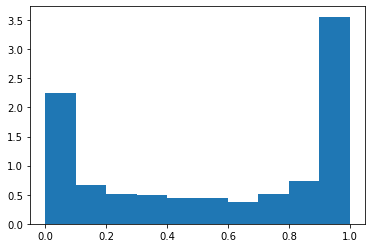

In [9]:
plt.hist(chi2_pvals, density=True)
plt.show()

yeah this doesn't look like a uniform distribution...

I am not sure I am using the correct number of degrees of freedom? 

hm, `11*2/2 + 11 + 2 - 1 = 67` seems right though actually so...

guess it just doesn't work, or at least not very well...

**Update:** reading more about $\chi^2$ tests, my guess now is that the issue is the very low number of expected counts for most/around half of the categories. Honestly one would have expected me to know this given that I taught students about this $\ge 5$ rule of thumb, but that was literally three years ago at this point (God I need to graduate already) and I never took those rules seriously, so I guess it's not that surprising that it came back to bite me

Anyway the point being that given my circumstances the $\chi^2$ _distribution_ is probably not a very good approximation to the sampling distribution of the $\chi^2$ _statistic_ under the multinomial distribution (which is the null that is supposed to be approximated and under which we would expect a uniform distribution for the $p$-values). This also seems kind of suggested by the fact that the histogram, while clearly not uniform, is sort of symmetric about/on the unit interval.

Anyway the "solution" as it were would be to use a better approximation (or implement some computationally expensive exact test which you'll never use again) which basically has to be Monte Carlo for reasons of practicality as well as efficacy (anything else I might try to develop independently would be an amount of work corresponding to its own project, it probably wouldn't work as well anyway).

So yeah in what follows let's try to implement Monte Carlo. OK? OK.

Note that the null distribution will be the same for all of the files since they all have the same frequency vector. So we just need to write a function which, given the frequency vector (and number of droplets), as well as a vector of $\chi^2$ statistics, can sample from the necessary multinomial distribution, create the empirical CDF, then pluck out the p-values for all of those statistics using that CDF.

OK yay

In [10]:
from statsmodels.distributions.empirical_distribution import ECDF
# wouldn't be very difficult to re-invent the wheel here, in fact I've already reinvented it before another notebook
# but it is more efficient/pragmatic re-using other people's code, plus it's fairly lightweight and has better
# error handling than I would implement, and finally is less error-prone than rewriting from scratch every time
# yes I guess I am ashamed of not computing the ECDF myself even though I can...

In [11]:
from simulations.global_chi2_cpm import get_exactly_1_or_2_strain_probs

In [12]:
def get_expected_probs(frequency_vector, rate=2):
    prob_empty_droplet = np.exp(-rate)
    exactly_1_or_2_strain_probs = get_exactly_1_or_2_strain_probs(
        frequency_vector, rate=rate
    )
    prob_multi_strain_droplet = (
        1.0 - np.sum(exactly_1_or_2_strain_probs) - prob_empty_droplet
    )
    return (
        prob_empty_droplet,
        exactly_1_or_2_strain_probs,
        prob_multi_strain_droplet,
    )

In [13]:
np.set_printoptions(linewidth=180, precision=5)

In [14]:
get_expected_probs(frequency_vector, 2)

(0.1353352832366127,
 array([[2.70941e-04, 5.42425e-07, 5.42425e-07, 5.42425e-07, 5.42425e-07, 5.42425e-07, 5.42425e-07, 5.42425e-07, 5.42425e-07, 5.42425e-07, 1.69142e-03],
        [0.00000e+00, 2.70941e-04, 5.42425e-07, 5.42425e-07, 5.42425e-07, 5.42425e-07, 5.42425e-07, 5.42425e-07, 5.42425e-07, 5.42425e-07, 1.69142e-03],
        [0.00000e+00, 0.00000e+00, 2.70941e-04, 5.42425e-07, 5.42425e-07, 5.42425e-07, 5.42425e-07, 5.42425e-07, 5.42425e-07, 5.42425e-07, 1.69142e-03],
        [0.00000e+00, 0.00000e+00, 0.00000e+00, 2.70941e-04, 5.42425e-07, 5.42425e-07, 5.42425e-07, 5.42425e-07, 5.42425e-07, 5.42425e-07, 1.69142e-03],
        [0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.70941e-04, 5.42425e-07, 5.42425e-07, 5.42425e-07, 5.42425e-07, 5.42425e-07, 1.69142e-03],
        [0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.70941e-04, 5.42425e-07, 5.42425e-07, 5.42425e-07, 5.42425e-07, 1.69142e-03],
        [0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 

In [15]:
probs_to_flatten = get_expected_probs(frequency_vector, 2)
probs = np.array([probs_to_flatten[0]] + list(probs_to_flatten[1].ravel()[np.flatnonzero(probs_to_flatten[1])]) + [probs_to_flatten[2]])

In [16]:
print(len(probs))
print(np.sum(probs))

68
1.0


In [17]:
rng = np.random.default_rng(42)

In [18]:
multinomial_trials = rng.multinomial(n=100000, pvals=probs, size=1000000)

In [19]:
multinomial_trials.shape

(1000000, 68)

given all of these multinoial trials, we need to calculate the corresponding $\chi^2$ statistics that would be sampled from them

each row of the trials (or each trial) is the observed counts. expected counts would then just `100000 * probs`

In [20]:
expected_counts = 100000 * probs

In [21]:
monte_carlo_chi2_stats = (multinomial_trials - expected_counts)**2 / expected_counts 

In [22]:
monte_carlo_chi2_stats[0,...]

array([ 2.9417 ,  0.56306,  0.05424,  0.05424,  0.05424,  0.05424,  0.05424,  0.05424,  0.05424,  0.05424,  0.05424,  2.33147,  0.88829,  0.05424,  0.05424,  0.05424, 16.48997,
        0.05424,  0.05424,  0.05424,  0.05424,  0.02712,  0.13406,  0.05424, 16.48997,  0.05424,  0.05424,  0.05424,  0.05424,  0.05424,  0.97749,  0.13406,  0.05424,  0.05424,
        0.05424,  0.05424,  0.05424,  0.05424,  0.36509,  0.13406,  0.05424,  0.05424,  0.05424,  0.05424,  0.05424,  0.08801,  0.95778,  0.05424,  0.05424,  0.05424,  0.05424,
        0.36509,  0.35335,  0.05424,  0.05424,  0.05424,  0.10142,  0.61866,  0.05424,  0.05424,  0.10142,  0.03029,  0.05424,  1.35551,  0.88829,  0.2029 ,  0.32092,  1.85471])

In [23]:
monte_carlo_chi2_stats.shape

(1000000, 68)

In [24]:
monte_carlo_chi2_stats = np.sum(monte_carlo_chi2_stats, axis=1)
monte_carlo_chi2_stats

array([51.04711, 55.14763, 95.53922, ..., 80.94939, 74.13227, 44.90978])

In [25]:
ecdf = ECDF(monte_carlo_chi2_stats)

remember ecdf gives probability less than or equal to, you want probability "more extreme than" which in this case means "larger", so 1 - CDF prob are the p-values

In [26]:
monte_carlo_pvals = 1. - ecdf(chi2_stats)

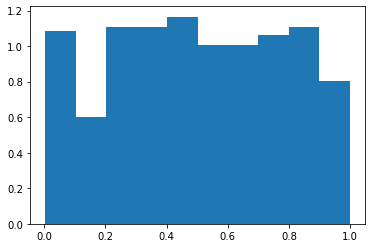

In [27]:
plt.hist(monte_carlo_pvals, density=True)
plt.show()

boom, uniform distribution. well you know, almost. anyway so yeah the explanation was just that the $chi^2$ distribution was an inadequate approximation to the null distribution in this case

also thank goodness Thar has lots of memory to allow me to run these crazy monte carlo simulations

In [28]:
from statsmodels.distributions.empirical_distribution import ECDF

def get_monte_carlo_ecdf(number_droplets, frequency_vector, rate=2, monte_carlo_seed=42, monte_carlo_trials=10000):

    probs_to_flatten = get_expected_probs(frequency_vector, rate=rate)
    probs = np.array([probs_to_flatten[0]] + list(probs_to_flatten[1].ravel()[np.flatnonzero(probs_to_flatten[1])]) + [probs_to_flatten[2]])

    rng = np.random.default_rng(monte_carlo_seed)
    multinomial_trials = rng.multinomial(n=number_droplets, pvals=probs, size=monte_carlo_trials)

    expected_counts = number_droplets * probs

    monte_carlo_chi2_stats = np.sum(((multinomial_trials - expected_counts)**2 / expected_counts), axis=1) 

    ecdf = ECDF(monte_carlo_chi2_stats)

    return ecdf

In [29]:
ecdf2 = get_monte_carlo_ecdf(100000, frequency_vector, rate, monte_carlo_trials=1000000)

In [30]:
np.all((1. - ecdf2(chi2_stats)) == monte_carlo_pvals)

True

OK good, the function encompasses/accomplishes my workflow -- now to add it to the Python module/package

In [31]:
from simulations.global_chi2_cpm import get_monte_carlo_ecdf as mc_func2

In [32]:
ecdf3 = mc_func2(100000, frequency_vector, rate, monte_carlo_trials=1000000)

In [33]:
np.all((1. - ecdf3(chi2_stats)) == monte_carlo_pvals)

True

OK great, awesome, all of the code seems to work as expected, yay

In [34]:
ecdf4 = mc_func2(100000, frequency_vector, rate, monte_carlo_trials=10000000)

as a side note, wow, am I ever glad that's it's always a computer that has to try to do these sorts of crazy/inefficient and yet still not very important calculations, and not me. because wow that would be unpleasant to even try (obviously I wouldn't be able to do it, well maybe after a million years but considering no one would want to be alive that long, that still kind of further supports my point(

In [37]:
higher_quality_monte_carlo_pvals = 1. - ecdf4(chi2_stats)

In [38]:
higher_quality_monte_carlo_pvals

array([0.698  , 0.53329, 0.51648, 0.81844, 0.09452, 0.48237, 0.34768, 0.86762, 0.55974, 0.52349, 0.46775, 0.41015, 0.14677, 0.46457, 0.94934, 0.47809, 0.32466, 0.64491, 0.91251,
       0.74581, 0.84585, 0.9626 , 0.42178, 0.27184, 0.28346, 0.28862, 0.24809, 0.31472, 0.27037, 0.00522, 0.61409, 0.45797, 0.36196, 0.09385, 0.64508, 0.51645, 0.82783, 0.24763,
       0.15402, 0.0131 , 0.79555, 0.38354, 0.30775, 0.85896, 0.68581, 0.18521, 0.48742, 0.8863 , 0.33859, 0.08473, 0.00348, 0.74468, 0.25291, 0.42102, 0.55778, 0.40701, 0.96736,
       0.32094, 0.72033, 0.12961, 0.73837, 0.20553, 0.78525, 0.28013, 0.74042, 0.96292, 0.84615, 0.53442, 0.53469, 0.89173, 0.12436, 0.80566, 0.74107, 0.60409, 0.691  , 0.36633,
       0.41941, 0.63605, 0.42717, 0.66403, 0.28267, 0.99887, 0.84636, 0.6929 , 0.11543, 0.89664, 0.60198, 0.83251, 0.60943, 0.37279, 0.43495, 0.62859, 0.15366, 0.83173, 0.48194,
       0.01939, 0.0279 , 0.68433, 0.5879 , 0.64393, 0.71879, 0.70444, 0.27634, 0.48872, 0.62868, 0.16097, 0.29

look at that high decimal precision (although I'm not sure if that's just rounding more than statistical closeness to the truth but whatever, we can detect in principle up to 10-7, which is pretty crazy from a Monte Carlo simulation imo)

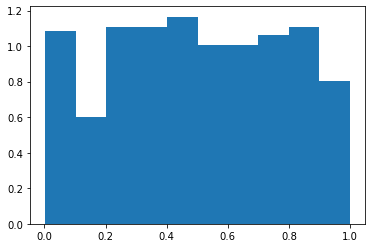

In [39]:
plt.hist(higher_quality_monte_carlo_pvals, density=True)
plt.show()

yeah did I mention the part about _pointless_ calculations? poor computer...